In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import torch
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR100, CIFAR10
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, TensorDataset

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

warnings.filterwarnings("ignore")

### Note

All Datasets will be of the format (N, C, H, W) with values between 0 and 1, unless stated otherwise.

This format is easier to deal with in PyTorch.

In [2]:
srmodel = torch.load('model/model_srresnet.pth')["model"]
srmodel = srmodel.cuda()

In [3]:
def generate_sr_dataset(dataset, model):
    sr_images, sr_targets = [], []    
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False, num_workers=4)
    for (inputs, targets) in tqdm(dataloader):
        with torch.no_grad():
            inputs = inputs.cuda()
            inputs = Variable(inputs).float()
            sr_inputs = model(inputs)
            sr_images.append(sr_inputs.cpu().numpy().astype(np.float32))
            sr_targets.append(targets.numpy().astype(np.int64))

    sr_images = np.concatenate(sr_images, axis=0).clip(0, 1)
    sr_targets = np.concatenate(sr_targets, axis=0)

    sr_images = torch.from_numpy(sr_images)
    sr_targets = torch.from_numpy(sr_targets)
    sr_dataset = TensorDataset(sr_images, sr_targets)
    return sr_dataset

In [4]:
trainset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
sr_trainset = generate_sr_dataset(trainset, srmodel)
sr_testset = generate_sr_dataset(testset, srmodel)

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
bc_trainset = CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
]))
bc_testset = CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
]))

Files already downloaded and verified
Files already downloaded and verified


In [7]:
sr_trainloader = DataLoader(sr_trainset, batch_size=64, shuffle=False, num_workers=4)
sr_testloader = DataLoader(sr_testset, batch_size=64, shuffle=False, num_workers=4)

bc_trainloader = DataLoader(bc_trainset, batch_size=64, shuffle=False, num_workers=4)
bc_testloader = DataLoader(bc_testset, batch_size=64, shuffle=False, num_workers=4)

torch.Size([64, 3, 128, 128]) torch.Size([64])


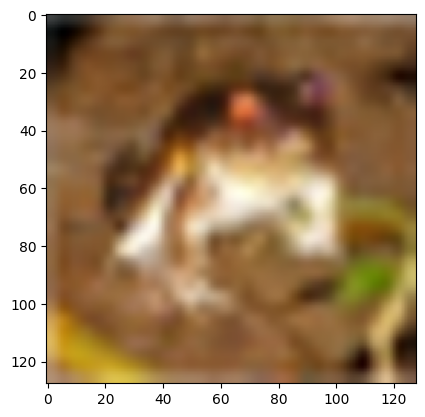

In [8]:
for i, (inputs, targets) in enumerate(bc_trainloader):
    print(inputs.shape, targets.shape)
    plt.imshow(inputs[0].permute(1, 2, 0))
    plt.show()
    break

torch.Size([64, 3, 128, 128]) torch.Size([64])


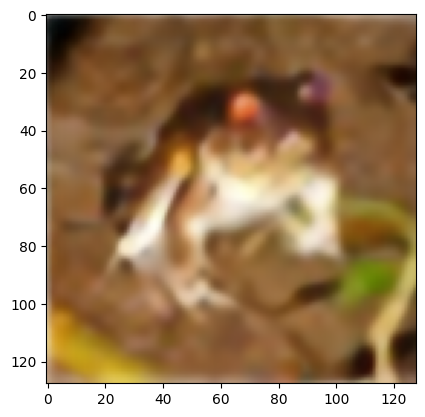

In [9]:
for i, (inputs, targets) in enumerate(sr_trainloader):
    print(inputs.shape, targets.shape)
    plt.imshow(inputs[0].permute(1, 2, 0))
    plt.show()
    break

### Training a CNN

In [10]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [11]:
def create_model(pretrain=True, out_channels=10):
    model = models.resnet18(pretrained=pretrain)
    model.fc = torch.nn.Linear(512, out_channels)
    model = model.cuda()
    return model


def train(model, trainloader, testloader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    accuracy = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(trainloader):
            inputs = inputs.cuda()
            targets = targets.cuda()
            inputs = Variable(inputs).float()
            targets = Variable(targets).long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        correct = 0
        total = 0
        with torch.no_grad():
            for (inputs, targets) in testloader:
                inputs = inputs.cuda()
                targets = targets.cuda()
                inputs = Variable(inputs).float()
                targets = Variable(targets).long()
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        print(f'Accuracy of the network on the 10000 test images: {(100 * correct / total):.2f} %')
        print('Loss on train set: ', running_loss / len(trainloader))
        accuracy.append(correct / total)
    return accuracy

In [12]:
model = create_model(True, 10)
bc_acc = train(model, bc_trainloader, bc_testloader, epochs=15)

torch.save(model.state_dict(), 'model/model_bc_finetune15_cifar10.pth')

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 91.59 %
Loss on train set:  0.43387436033095544
Accuracy of the network on the 10000 test images: 92.80 %
Loss on train set:  0.14348806048769627
Accuracy of the network on the 10000 test images: 93.06 %
Loss on train set:  0.0604478717600579
Accuracy of the network on the 10000 test images: 93.23 %
Loss on train set:  0.023512321584464986
Accuracy of the network on the 10000 test images: 93.27 %
Loss on train set:  0.010516600191171574
Accuracy of the network on the 10000 test images: 93.39 %
Loss on train set:  0.005859322481505249
Accuracy of the network on the 10000 test images: 93.48 %
Loss on train set:  0.00385011820626669
Accuracy of the network on the 10000 test images: 93.41 %
Loss on train set:  0.0028013344122426787
Accuracy of the network on the 10000 test images: 93.40 %
Loss on train set:  0.00218250125798735
Accuracy of the network on the 10000 test images: 93.42 %
Loss on train set:  0.0017778920071512755
Accuracy of th

In [13]:
model = create_model(True, 10)
sr_acc = train(model, sr_trainloader, sr_testloader, epochs=15)

torch.save(model.state_dict(), 'model/model_sr_finetune15_cifar10.pth')

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 92.63 %
Loss on train set:  0.3689541431129589
Accuracy of the network on the 10000 test images: 93.55 %
Loss on train set:  0.11591447313861622
Accuracy of the network on the 10000 test images: 93.81 %
Loss on train set:  0.04714824626450915
Accuracy of the network on the 10000 test images: 93.95 %
Loss on train set:  0.01853370755289198
Accuracy of the network on the 10000 test images: 94.06 %
Loss on train set:  0.008667331011167935
Accuracy of the network on the 10000 test images: 94.11 %
Loss on train set:  0.005002234672235511
Accuracy of the network on the 10000 test images: 94.07 %
Loss on train set:  0.003388653173694349
Accuracy of the network on the 10000 test images: 94.11 %
Loss on train set:  0.0025311363720283858
Accuracy of the network on the 10000 test images: 94.12 %
Loss on train set:  0.0020032560411805543
Accuracy of the network on the 10000 test images: 94.14 %
Loss on train set:  0.0016468066594946314
Accuracy of 

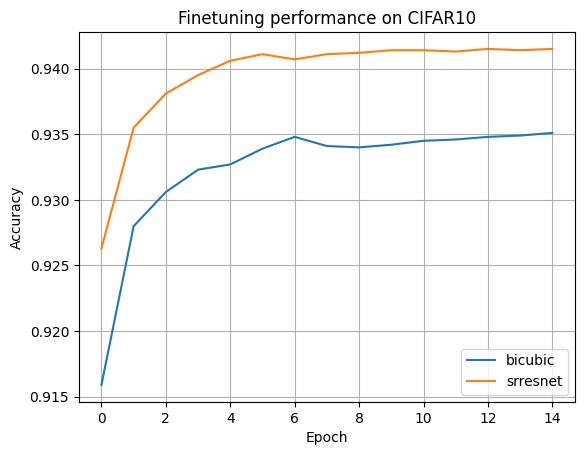

In [14]:
plt.plot(bc_acc, label='bicubic')
plt.plot(sr_acc, label='srresnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Finetuning performance on CIFAR10')
plt.legend()
plt.grid()
plt.show()

In [15]:
model = create_model(False, 10)
bc_acc = train(model, bc_trainloader, bc_testloader, epochs=100)

torch.save(model.state_dict(), 'model/model_bc_scratch100_cifar10.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 50.39 %
Loss on train set:  1.6478351712836634
Accuracy of the network on the 10000 test images: 59.21 %
Loss on train set:  1.2403321719687919
Accuracy of the network on the 10000 test images: 63.16 %
Loss on train set:  1.0256556344154242
Accuracy of the network on the 10000 test images: 65.86 %
Loss on train set:  0.859959886583221
Accuracy of the network on the 10000 test images: 67.39 %
Loss on train set:  0.7124951863304123
Accuracy of the network on the 10000 test images: 66.29 %
Loss on train set:  0.5623398556390686
Accuracy of the network on the 10000 test images: 65.57 %
Loss on train set:  0.42492770940980035
Accuracy of the network on the 10000 test images: 66.86 %
Loss on train set:  0.2949928437714534
Accuracy of the network on the 10000 test images: 66.89 %
Loss on train set:  0.20241313904542904
Accuracy of the network on the 10000 test images: 67.31 %
Loss on train set:  0.14270623816210595
Accuracy of the network on t

In [16]:
model = create_model(False, 10)
sr_acc = train(model, sr_trainloader, sr_testloader, epochs=100)

torch.save(model.state_dict(), 'model/model_sr_scratch100_cifar10.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 52.70 %
Loss on train set:  1.6148370879385479
Accuracy of the network on the 10000 test images: 62.21 %
Loss on train set:  1.1591071601566452
Accuracy of the network on the 10000 test images: 65.99 %
Loss on train set:  0.9335649364134845
Accuracy of the network on the 10000 test images: 68.86 %
Loss on train set:  0.7735847490827751
Accuracy of the network on the 10000 test images: 69.88 %
Loss on train set:  0.6281755883294298
Accuracy of the network on the 10000 test images: 68.77 %
Loss on train set:  0.48941299999537674
Accuracy of the network on the 10000 test images: 69.27 %
Loss on train set:  0.3535269239674444
Accuracy of the network on the 10000 test images: 67.48 %
Loss on train set:  0.23571983447103093
Accuracy of the network on the 10000 test images: 68.59 %
Loss on train set:  0.15743474877627608
Accuracy of the network on the 10000 test images: 70.29 %
Loss on train set:  0.10908183120989033
Accuracy of the network on

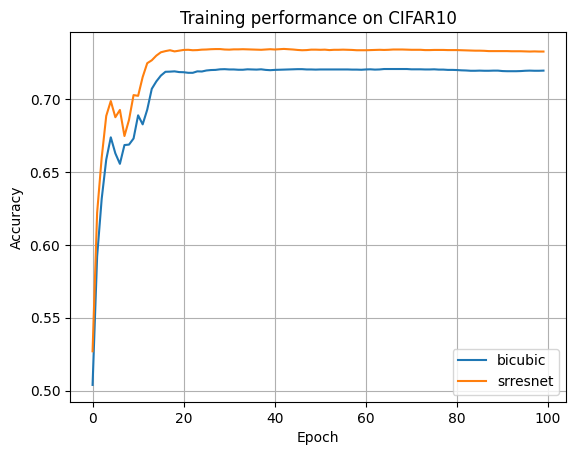

In [17]:
plt.plot(bc_acc, label='bicubic')
plt.plot(sr_acc, label='srresnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training performance on CIFAR10')
plt.legend()
plt.grid()
plt.show()